In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def load_pc_from_bin(bin_path):
    obj= np.fromfile(bin_path,dtype=np.float32).reshape(-1,4)
    return obj

In [3]:
# scale to 255
def scale_to_255(a, min,max,dtype=np.uint8):
    return (((a-min)/float(max-min))*255).astype(dtype)

In [4]:
def point_cloud_to_panorama(points,
                            v_res=0.42,
                            h_res = 0.08,
                            v_fov = (-24.9, 2.0),
                            d_range = (0,100),
                            y_fudge=3
                            ):
    """ Takes point cloud data as input and creates a 360 degree panoramic
        image, returned as a numpy array.
    Args:
        points: (np array)
            The numpy array containing the point cloud. .
            The shape should be at least Nx3 (allowing for more columns)
            - Where N is the number of points, and
            - each point is specified by at least 3 values (x, y, z)
        v_res: (float)
            vertical angular resolution in degrees. This will influence the
            height of the output image.
        h_res: (float)
            horizontal angular resolution in degrees. This will influence
            the width of the output image.
        v_fov: (tuple of two floats)
            Field of view in degrees (-min_negative_angle, max_positive_angle)
        d_range: (tuple of two floats) (default = (0,100))
            Used for clipping distance values to be within a min and max range.
        y_fudge: (float)
            A hacky fudge factor to use if the theoretical calculations of
            vertical image height do not match the actual data.
    Returns:
        A numpy array representing a 360 degree panoramic image of the point
        cloud.
    """
    # Projecting to 2D
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]
    r_points = points[:, 3]
    d_points = np.sqrt(x_points ** 2 + y_points ** 2)  # map distance relative to origin
    #d_points = np.sqrt(x_points**2 + y_points**2 + z_points**2) # abs distance

    # We use map distance, because otherwise it would not project onto a cylinder,
    # instead, it would map onto a segment of slice of a sphere.

    # RESOLUTION AND FIELD OF VIEW SETTINGS
    v_fov_total = -v_fov[0] + v_fov[1]

    # CONVERT TO RADIANS
    v_res_rad = v_res * (np.pi / 180)
    h_res_rad = h_res * (np.pi / 180)

    # MAPPING TO CYLINDER
    x_img = np.arctan2(y_points, x_points) / h_res_rad
    y_img = -(np.arctan2(z_points, d_points) / v_res_rad)

    # THEORETICAL MAX HEIGHT FOR IMAGE
    d_plane = (v_fov_total/v_res) / (v_fov_total* (np.pi / 180))
    h_below = d_plane * np.tan(-v_fov[0]* (np.pi / 180))
    h_above = d_plane * np.tan(v_fov[1] * (np.pi / 180))
    y_max = int(np.ceil(h_below+h_above + y_fudge))

    # SHIFT COORDINATES TO MAKE 0,0 THE MINIMUM
    x_min = -360.0 / h_res / 2
    x_img = np.trunc(-x_img - x_min).astype(np.int32)
    x_max = int(np.ceil(360.0 / h_res))

    y_min = -((v_fov[1] / v_res) + y_fudge)
    y_img = np.trunc(y_img - y_min).astype(np.int32)

    # CLIP DISTANCES
    d_points = np.clip(d_points, a_min=d_range[0], a_max=d_range[1])

    # CONVERT TO IMAGE ARRAY
    img = np.zeros([y_max + 1, x_max + 1], dtype=np.uint8)
    img[y_img, x_img] = scale_to_255(d_points, min=d_range[0], max=d_range[1])

    return img

def lidar_to_2d_front_view(points,
                           v_res,
                           h_res,
                           v_fov,
                           val="depth",
                           cmap="jet",
                           saveto=None,
                           y_fudge=0.0
                           ):
    """ Takes points in 3D space from LIDAR data and projects them to a 2D
        "front view" image, and saves that image.
    Args:
        points: (np array)
            The numpy array containing the lidar points.
            The shape should be Nx4
            - Where N is the number of points, and
            - each point is specified by 4 values (x, y, z, reflectance)
        v_res: (float)
            vertical resolution of the lidar sensor used.
        h_res: (float)
            horizontal resolution of the lidar sensor used.
        v_fov: (tuple of two floats)
            (minimum_negative_angle, max_positive_angle)
        val: (str)
            What value to use to encode the points that get plotted.
            One of {"depth", "height", "reflectance"}
        cmap: (str)
            Color map to use to color code the `val` values.
            NOTE: Must be a value accepted by matplotlib's scatter function
            Examples: "jet", "gray"
        saveto: (str or None)
            If a string is provided, it saves the image as this filename.
            If None, then it just shows the image.
        y_fudge: (float)
            A hacky fudge factor to use if the theoretical calculations of
            vertical range do not match the actual data.
            For a Velodyne HDL 64E, set this value to 5.
    """

    # DUMMY PROOFING
    assert len(v_fov) ==2, "v_fov must be list/tuple of length 2"
    assert v_fov[0] <= 0, "first element in v_fov must be 0 or negative"
    assert val in {"depth", "height", "reflectance"}, \
        'val must be one of {"depth", "height", "reflectance"}'


    x_lidar = points[:, 0]
    y_lidar = points[:, 1]
    z_lidar = points[:, 2]
    r_lidar = points[:, 3] # Reflectance
    # Distance relative to origin when looked from top
    #d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2)
    # Absolute distance relative to origin
    d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2, z_lidar ** 2)

    v_fov_total = -v_fov[0] + v_fov[1]

    # Convert to Radians
    v_res_rad = v_res * (np.pi/180)
    h_res_rad = h_res * (np.pi/180)

    # PROJECT INTO IMAGE COORDINATES
    x_img = np.arctan2(-y_lidar, x_lidar)/ h_res_rad
    y_img = np.arctan2(z_lidar, d_lidar)/ v_res_rad

    # SHIFT COORDINATES TO MAKE 0,0 THE MINIMUM
    x_min = -360.0 / h_res / 2  # Theoretical min x value based on sensor specs
    x_img -= x_min              # Shift
    x_max = 360.0 / h_res       # Theoretical max x value after shifting

    y_min = v_fov[0] / v_res    # theoretical min y value based on sensor specs
    y_img -= y_min              # Shift
    y_max = v_fov_total / v_res # Theoretical max x value after shifting

    y_max += y_fudge            # Fudge factor if the calculations based on
                                # spec sheet do not match the range of
                                # angles collected by in the data.
    #print x_min,y_min
    #print x_max,y_max
    # WHAT DATA TO USE TO ENCODE THE VALUE FOR EACH PIXEL
    if val == "reflectance":
        pixel_values = r_lidar
    elif val == "height":
        pixel_values = z_lidar
    else:
        pixel_values = -d_lidar

    # PLOT THE IMAGE
    cmap = "jet"            # Color map to use
    dpi = 100               # Image resolution
    fig, ax = plt.subplots(figsize=(x_max/dpi, y_max/dpi), dpi=dpi)
    ax.scatter(x_img,y_img, s=1, c=pixel_values, linewidths=0, alpha=1, cmap=cmap)
    
    ax.set_axis_bgcolor((0, 0, 0)) # Set regions with no points to black
    ax.axis('scaled')              # {equal, scaled}
    ax.xaxis.set_visible(False)    # Do not draw axis tick marks
    ax.yaxis.set_visible(False)    # Do not draw axis tick marks
    plt.xlim([0, x_max])   # prevent drawing empty space outside of horizontal FOV
    plt.ylim([0, y_max])   # prevent drawing empty space outside of vertical FOV

    if saveto is not None:
        fig.savefig(saveto, dpi=dpi, bbox_inches='tight', pad_inches=0.0)
    else:
        fig.show()

        
def lidar_to_2d_front_view_for_npy(points,
                           v_res,
                           h_res,
                           v_fov,
                           val="depth",
                           cmap="jet",
                           saveto=None,
                           y_fudge=0.0
                           ):
    """ Takes points in 3D space from LIDAR data and projects them to a 2D
        "front view" image, and saves that image.
    Args:
        points: (np array)
            The numpy array containing the lidar points.
            The shape should be Nx4
            - Where N is the number of points, and
            - each point is specified by 4 values (x, y, z, reflectance)
        v_res: (float)
            vertical resolution of the lidar sensor used.
        h_res: (float)
            horizontal resolution of the lidar sensor used.
        v_fov: (tuple of two floats)
            (minimum_negative_angle, max_positive_angle)
        val: (str)
            What value to use to encode the points that get plotted.
            One of {"depth", "height", "reflectance"}
        cmap: (str)
            Color map to use to color code the `val` values.
            NOTE: Must be a value accepted by matplotlib's scatter function
            Examples: "jet", "gray"
        saveto: (str or None)
            If a string is provided, it saves the image as this filename.
            If None, then it just shows the image.
        y_fudge: (float)
            A hacky fudge factor to use if the theoretical calculations of
            vertical range do not match the actual data.
            For a Velodyne HDL 64E, set this value to 5.
    """

    # DUMMY PROOFING
    assert len(v_fov) ==2, "v_fov must be list/tuple of length 2"
    assert v_fov[0] <= 0, "first element in v_fov must be 0 or negative"
    assert val in {"depth", "height", "reflectance"}, \
        'val must be one of {"depth", "height", "reflectance"}'


    x_lidar = points[:,:,0]
    y_lidar = points[:,:,1]
    z_lidar = points[:,:,2]
    r_lidar = points[:,:,3] # Reflectance
    # Distance relative to origin when looked from top
    #d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2)
    # Absolute distance relative to origin
    d_lidar = np.sqrt(x_lidar ** 2 + y_lidar ** 2, z_lidar ** 2)

    v_fov_total = -v_fov[0] + v_fov[1]

    # Convert to Radians
    v_res_rad = v_res * (np.pi/180)
    h_res_rad = h_res * (np.pi/180)

    # PROJECT INTO IMAGE COORDINATES
    x_img = np.arctan2(-y_lidar, x_lidar)/ h_res_rad
    y_img = np.arctan2(z_lidar, d_lidar)/ v_res_rad

    # SHIFT COORDINATES TO MAKE 0,0 THE MINIMUM
    x_min = -360.0 / h_res / 2  # Theoretical min x value based on sensor specs
    x_img -= x_min              # Shift
    x_max = 360.0 / h_res       # Theoretical max x value after shifting

    y_min = v_fov[0] / v_res    # theoretical min y value based on sensor specs
    y_img -= y_min              # Shift
    y_max = v_fov_total / v_res # Theoretical max x value after shifting

    y_max += y_fudge            # Fudge factor if the calculations based on
                                # spec sheet do not match the range of
                                # angles collected by in the data.
    # WHAT DATA TO USE TO ENCODE THE VALUE FOR EACH PIXEL
    if val == "reflectance":
        pixel_values = r_lidar
    elif val == "height":
        pixel_values = z_lidar
    else:
        pixel_values = -d_lidar

    # PLOT THE IMAGE
    cmap = "jet"            # Color map to use
    dpi = 100               # Image resolution
    fig, ax = plt.subplots(figsize=(x_max/dpi, y_max/dpi), dpi=dpi)
    ax.scatter(x_img,y_img, s=1, c=pixel_values, linewidths=0, alpha=1, cmap=cmap)
    
    ax.set_axis_bgcolor((0, 0, 0)) # Set regions with no points to black
    ax.axis('scaled')              # {equal, scaled}
    ax.xaxis.set_visible(False)    # Do not draw axis tick marks
    ax.yaxis.set_visible(False)    # Do not draw axis tick marks
    plt.xlim([0, x_max])   # prevent drawing empty space outside of horizontal FOV
    plt.ylim([0, y_max])   # prevent drawing empty space outside of vertical FOV

    if saveto is not None:
        fig.savefig(saveto, dpi=dpi, bbox_inches='tight', pad_inches=0.0)
    else:
        fig.show()

In [5]:
#record = np.load('data/Mems/004004.npy').astype(np.float32,copy=False)
record = np.load('data/lidar_2d/2011_09_26_0001_0000000054.npy').astype(np.float32,copy=False)
#lidar=record[:,:,:4]
record = record.reshape((64,512,6))
lidar=record[:,:,:4]

# print record.shape
# print lidar[:,:,0]

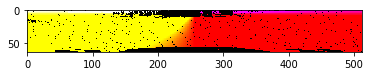

In [11]:

plt.imshow(record[:,:,0:3])

In [10]:
plt.imshow(record[:,:,5])
a=record[:,:,5]
print a[0:25,300:325]

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-10-0897369d8e87>, line 3)

In [ ]:
record = np.load('data/Mems/2011_09_26_drive_0001_sync/0000000002.npy').astype(np.float32,copy=False)

plt.imshow(record[:,:,5])
print a[0:25,300:325]

In [ ]:
plt.imshow(record[:,:,4])

In [ ]:
root = lidar[:,:,0]
root = root.reshape(-1,1)
for i in range(lidar.shape[2]-1):
    
    tran = lidar[:,:,i+1]
    tran = tran.reshape(-1,1)
    buffe_ =tran
    root = np.hstack((root,buffe_))

In [ ]:
print root.shape
print root[:,0]


In [ ]:
HRES = 0.35        # horizontal resolution (assuming 20Hz setting)
VRES = 0.4       # vertical res
VFOV = (-24,9) # Field of view (-ve, +ve) along vertical axis
Y_FUDGE = 4  
img=point_cloud_to_panorama(root, v_res=VRES, h_res=HRES, v_fov=VFOV,
                       y_fudge=Y_FUDGE)

plt.imshow(img)

In [ ]:
record = np.fromfile('0000000003.bin',dtype=np.float32).reshape(-1,4)
print record.shape

In [ ]:
HRES = 0.35         # horizontal resolution (assuming 20Hz setting)
VRES = 0.4          # vertical res
VFOV = (-24.9, 2.0) # Field of view (-ve, +ve) along vertical axis
Y_FUDGE = 5  
lidar_to_2d_front_view(record, v_res=VRES, h_res=HRES, v_fov=VFOV,
                       val="depth", saveto=None,
                       y_fudge=Y_FUDGE)